In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import warnings
warnings.filterwarnings("ignore")

# Catfish Sales Data

In [39]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [40]:
#read data
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [41]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [42]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

In [43]:
#At December 1 1998
lim_catfish_sales[datetime(1998,12,1)] = 11000

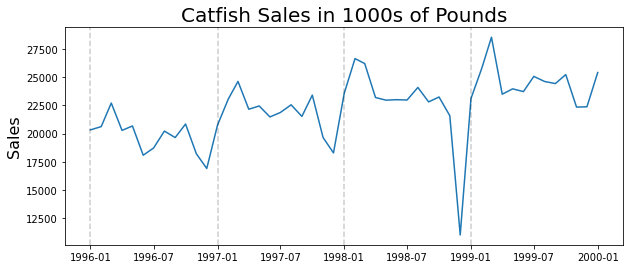

In [44]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [45]:
first_diff = lim_catfish_sales.diff()[1:]

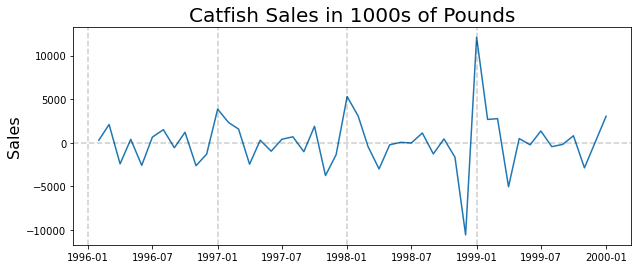

In [46]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# Get training and testing sets

In [47]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

# Make Predictions

In [48]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)

In [49]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

In [50]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

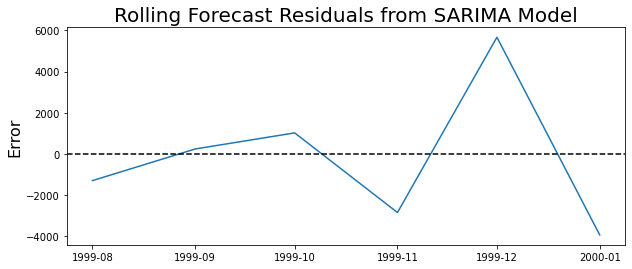

In [51]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

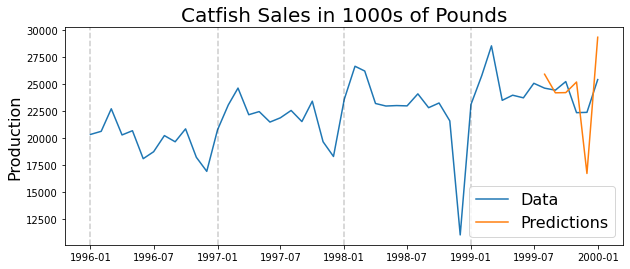

In [52]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [53]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.1064


In [54]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 3121.390155043102


# Detecting the Anomaly

## Attempt 1: Deviation Method

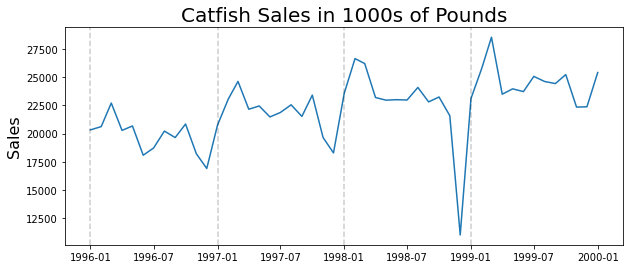

In [55]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [56]:
rolling_deviations = pd.Series(dtype=float, index = lim_catfish_sales.index)

In [57]:
for date in rolling_deviations.index:
    #get the window ending at this data point
    window = lim_catfish_sales.loc[:date]
    
    #get the deviation within this window
    rolling_deviations.loc[date] = window.std()

In [58]:
#get the difference in deviation between one time point and the next
diff_rolling_deviations = rolling_deviations.diff()
diff_rolling_deviations = diff_rolling_deviations.dropna()

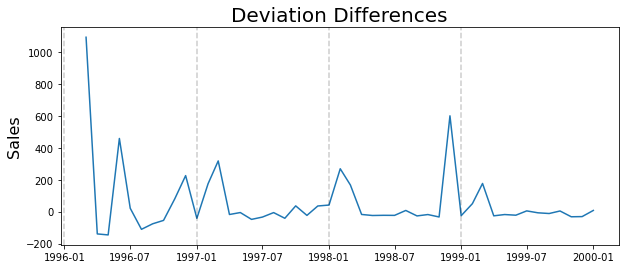

In [59]:
plt.figure(figsize=(10,4))
plt.plot(diff_rolling_deviations)
plt.title('Deviation Differences', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Attempt 2: Seasonal Method

In [60]:
month_deviations = lim_catfish_sales.groupby(lambda d: d.month).std()

Text(0, 0.5, 'Sales')

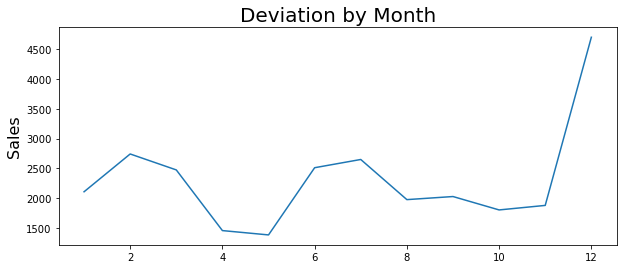

In [61]:
plt.figure(figsize=(10,4))
plt.plot(month_deviations)
plt.title('Deviation by Month', fontsize=20)
plt.ylabel('Sales', fontsize=16)

## So, the anomaly occurs in a December

In [62]:
december_data = lim_catfish_sales[lim_catfish_sales.index.month == 12]

In [63]:
december_data

Date
1996-12-01    16898
1997-12-01    18278
1998-12-01    11000
1999-12-01    22372
Name: Total, dtype: int64

In [64]:
min_dev = 9999999
curr_anomaly = None
for date in december_data.index:
    other_data = december_data[december_data.index != date]
    curr_dev = other_data.std()
    if curr_dev < min_dev:
        min_dev = curr_dev
        curr_anomaly = date

In [65]:
curr_anomaly

Timestamp('1998-12-01 00:00:00')

# What to do about the anomaly?

## Simple Idea: use mean of other months

In [66]:
adjusted_data = lim_catfish_sales.copy()
adjusted_data.loc[curr_anomaly] = december_data[(december_data.index != curr_anomaly) & (december_data.index < test_data.index[0])].mean()

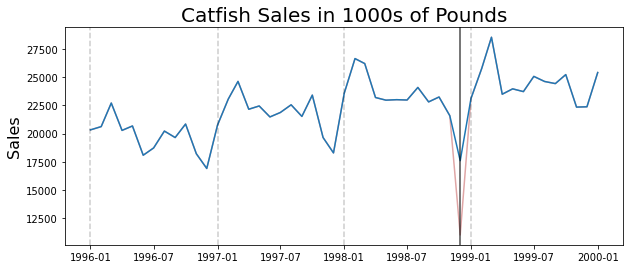

In [67]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales, color='firebrick', alpha=0.4)
plt.plot(adjusted_data)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(curr_anomaly, color='k', alpha=0.7)

# Resulting Predictions

In [68]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = adjusted_data[train_end + timedelta(days=1):test_end]

In [69]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = adjusted_data[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

In [70]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

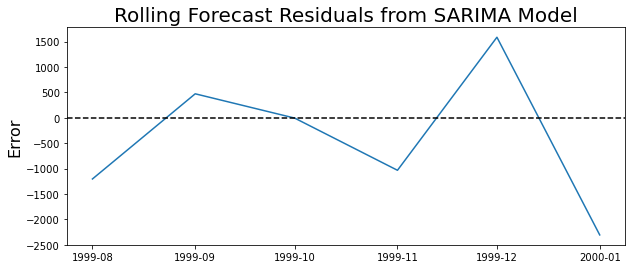

In [71]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

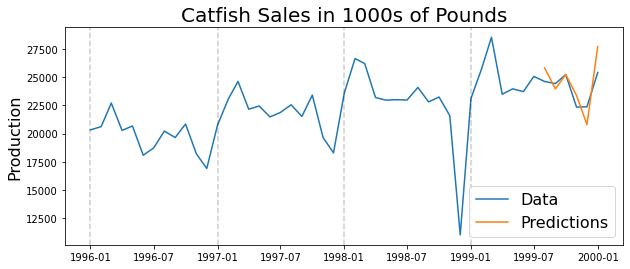

In [72]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [73]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0461


In [37]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 1327.2630359754116
